In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,Bidirectional,GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
import datetime
import io
import itertools
# import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import sys
import os
# Obtener la ruta del directorio actual
os.chdir('..')
current_dir = os.getcwd()
print(current_dir)

# Construir la ruta relativa al directorio que quieres agregar
relative_dir = os.path.join(current_dir, 'mis_pkgs/')

# Agregar la ruta relativa al sys.path
sys.path.insert(0, relative_dir)

from MIOPATIA_db import DB_management as db 


i:\nuevas_investigaciones_alimentos_2024


In [2]:
numero_muestras=401
numero_clases=2
entrada=slice(5,6)
numero_entradas = entrada.stop - entrada.start
numero_epochs=2000

Voy a quedarme con los 50 atunes P1 para obtener conjunto de training y validacion

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, Activation, Concatenate, Conv2D, Dropout 
from tensorflow.keras.layers import Flatten, Input, GlobalAveragePooling2D, MaxPooling2D
import tensorflow.keras.backend as K

__version__ = '0.0.1'


def SqueezeNet(input_shape, nb_classes, use_bypass=False, dropout_rate=None, compression=1.0):
    """
    Creating a SqueezeNet of version 1.0
    
    Arguments:
        input_shape  : shape of the input images e.g. (224,224,3)
        nb_classes   : number of classes
        use_bypass   : if true, bypass connections will be created at fire module 3, 5, 7, and 9 (default: False)
        dropout_rate : defines the dropout rate that is accomplished after last fire module (default: None)
        compression  : reduce the number of feature-maps (default: 1.0)
        
    Returns:
        Model        : Keras model instance
    """
    
    input_img = Input(shape=input_shape)

    x = Conv2D(int(96*compression), (7,7), activation='relu', strides=(2,2), padding='same', name='conv1')(input_img)

    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool1')(x)
    
    x = create_fire_module(x, int(16*compression), name='fire2')
    x = create_fire_module(x, int(16*compression), name='fire3', use_bypass=use_bypass)
    x = create_fire_module(x, int(32*compression), name='fire4')
    
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool4')(x)
    
    x = create_fire_module(x, int(32*compression), name='fire5', use_bypass=use_bypass)
    x = create_fire_module(x, int(48*compression), name='fire6')
    x = create_fire_module(x, int(48*compression), name='fire7', use_bypass=use_bypass)
    x = create_fire_module(x, int(64*compression), name='fire8')
    
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool8')(x)
    
    x = create_fire_module(x, int(64*compression), name='fire9', use_bypass=use_bypass)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)
        
    x = output(x, nb_classes)

    return Model(inputs=input_img, outputs=x)


def SqueezeNet_11(input_shape, nb_classes, dropout_rate=None, compression=1.0):
    """
    Creating a SqueezeNet of version 1.1
    
    2.4x less computation over SqueezeNet 1.0 implemented above.
    
    Arguments:
        input_shape  : shape of the input images e.g. (224,224,3)
        nb_classes   : number of classes
        dropout_rate : defines the dropout rate that is accomplished after last fire module (default: None)
        compression  : reduce the number of feature-maps
        
    Returns:
        Model        : Keras model instance
    """
    
    input_img = Input(shape=input_shape)

    x = Conv2D(int(64*compression), (3,3), activation='relu', strides=(2,2), padding='same', name='conv1')(input_img)

    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool1')(x)
    
    x = create_fire_module(x, int(16*compression), name='fire2')
    x = create_fire_module(x, int(16*compression), name='fire3')
    
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool3')(x)
    
    x = create_fire_module(x, int(32*compression), name='fire4')
    x = create_fire_module(x, int(32*compression), name='fire5')
    
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool5')(x)
    
    x = create_fire_module(x, int(48*compression), name='fire6')
    x = create_fire_module(x, int(48*compression), name='fire7')
    x = create_fire_module(x, int(64*compression), name='fire8')
    x = create_fire_module(x, int(64*compression), name='fire9')

    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    
    # Creating last conv10
    x = output(x, nb_classes)

    return Model(inputs=input_img, outputs=x)


def output(x, nb_classes):
    x = Conv2D(nb_classes, (1,1), strides=(1,1), padding='valid', name='conv10')(x)
    x = GlobalAveragePooling2D(name='avgpool10')(x)
    x = Activation("softmax", name='softmax')(x)
    return x


def create_fire_module(x, nb_squeeze_filter, name, use_bypass=False):
    """
    Creates a fire module
    
    Arguments:
        x                 : input
        nb_squeeze_filter : number of filters of squeeze. The filtersize of expand is 4 times of squeeze
        use_bypass        : if True then a bypass will be added
        name              : name of module e.g. fire123
    
    Returns:
        x                 : returns a fire module
    """
    
    nb_expand_filter = 4 * nb_squeeze_filter
    squeeze    = Conv2D(nb_squeeze_filter,(1,1), activation='relu', padding='same', name='%s_squeeze'%name)(x)
    expand_1x1 = Conv2D(nb_expand_filter, (1,1), activation='relu', padding='same', name='%s_expand_1x1'%name)(squeeze)
    expand_3x3 = Conv2D(nb_expand_filter, (3,3), activation='relu', padding='same', name='%s_expand_3x3'%name)(squeeze)
    
    axis = get_axis()
    x_ret = Concatenate(axis=axis, name='%s_concatenate'%name)([expand_1x1, expand_3x3])
    
    if use_bypass:
        x_ret = Add(name='%s_concatenate_bypass'%name)([x_ret, x])
        
    return x_ret


def get_axis():
    axis = -1 if K.image_data_format() == 'channels_last' else 1
    return axis


In [4]:
filename = "COPIA_PANDAS\hdf_lomosAgilent_trainval_filtrado_def_good_ampliado_the_best7.hdf"
with pd.HDFStore(filename,complib="zlib",complevel=4) as hdf_db:
    pre_p_e1  = hdf_db.get('data/pollos_estado')
    pre_p_e1 = pre_p_e1.loc[pre_p_e1['Pollo'] != 0]
    # p_e =pre_p_e1.drop_duplicates(subset = ['Pollo', 'Medida'],  keep = 'last').reset_index(drop = True)
    t    = hdf_db.get('data/tabla')
    X_train=np.zeros((pre_p_e1.shape[0],numero_muestras,numero_entradas))
    y_train=np.zeros((pre_p_e1.shape[0],1))
    x=0
    for index, row in pre_p_e1.iterrows():   # El primer registro no se toma en cuenta porque es basura
        Primero = int(row['Primero'])
        Ultimo  = int(row['Ultimo'])
        estado  = int(row['Estado'])
        #print(Primero)
        #print(Ultimo)
        #print(estado)
        if numero_clases==2:
            if estado == 0 or estado== 1:
                target = 0
            else:
                target = 1
        else:
            target=estado
        pepito=np.array(t.iloc[Primero:Ultimo+1])
        # #print(pepito.shape)
        X_train[x]=pepito[:,entrada]
        #X_train[x]=X_train[x].reshape(X_train[x].shape[0],-1)
        #print(X_train[x][0:4,:])       
        y_train[x]=target
        y_train_to_categorical = to_categorical(y_train)
        x=x+1


# print(X_train.shape)
# print(y_train_to_categorical.shape)
# #print(X_train[0:4,:,:])
# #print(X_train[1][0:4][:])
# print(y_train[1:20])
# print(y_train_to_categorical[1:20])
# # #Aqui filtrariamos si hay filas que no nos interesan. En este caso dejo pasar todos los casos
# print(p_e)
# # X_train_filtrado = X_train[2:][:,:]
# # y_train_filtrado = y_train[2:]
X_train_filtrado = X_train
#y_train_filtrado = y_train
y_train_filtrado = y_train_to_categorical

# print(X_train_filtrado.shape)
# print(y_train_filtrado.shape)
# print(X_train_filtrado[0][:,:])
# # # Vamos a normalizar o escalar los datos
scaler = StandardScaler()
data_2d = X_train_filtrado.reshape(-1, X_train_filtrado.shape[-1])
normalized_data_2d = scaler.fit_transform(data_2d)
#para recurrentes
#X_train_Normalizado=normalized_data_2d.reshape(X_train_filtrado.shape) #para recurrentes
#para densas
X_train_Normalizado=normalized_data_2d.reshape(X_train_filtrado.shape[0],-1)
y_train_Normalizado=y_train_filtrado # los valores ya estaban normalizados
print(y_train_Normalizado.shape)

(53, 2)


In [5]:
filename = "COPIA_PANDAS\hdf_lomosAgilent_test_filtrado_def_good.hdf"
with pd.HDFStore(filename,complib="zlib",complevel=4) as hdf_db:
    pre_p_e1  = hdf_db.get('data/pollos_estado')
    pre_p_e1 = pre_p_e1.loc[pre_p_e1['Pollo'] != 0]
    pre_p_e1 =pre_p_e1.drop_duplicates(subset = ['Pollo', 'Medida'],  keep = 'last').reset_index(drop = True)
    t    = hdf_db.get('data/tabla')
    X_test=np.zeros((pre_p_e1.shape[0],numero_muestras,numero_entradas))
    y_test=np.zeros((pre_p_e1.shape[0],1))
    x=0
    for index, row in pre_p_e1.iterrows():   # El primer registro no se toma en cuenta porque es basura
        Primero = int(row['Primero'])
        Ultimo  = int(row['Ultimo'])
        estado  = int(row['Estado'])
        #print(Primero)
        #print(Ultimo)
        #print(estado)
        if numero_clases==2:
            if estado == 0 or estado== 1:
                target = 0
            else:
                target = 1

        else:
            target=estado
        pepito=np.array(t.iloc[Primero:Ultimo+1])
        # #print(pepito.shape)
        X_test[x]=pepito[:,entrada]
        #print(X_train[x][0:4,:])       
        y_test[x]=target
        y_test_to_categorical = to_categorical(y_test)
        x=x+1


# print(X_train.shape)
# print(y_train_to_categorical.shape)
# #print(X_train[0:4,:,:])
# #print(X_train[1][0:4][:])
# print(y_train[1:20])
# print(y_train_to_categorical[1:20])
# # #Aqui filtrariamos si hay filas que no nos interesan. En este caso dejo pasar todos los casos
# print(p_e)
# # X_train_filtrado = X_train[2:][:,:]
# # y_train_filtrado = y_train[2:]
X_test_filtrado = X_test
#y_train_filtrado = y_train
y_test_filtrado = y_test_to_categorical

print(X_test_filtrado.shape)
print(y_test_filtrado.shape)
# print(X_train_filtrado[0][:,:])
# # # Vamos a normalizar o escalar los datos
# concatenamos train y test
#X_total=np.concatenate((X_train_filtrado,X_test_filtrado),axis=0)
#scaler = MinMaxScaler(feature_range=(0, 1))
#data_2d_test = X_total.reshape(-1, X_total.shape[-1])
data_2d_test = X_test_filtrado.reshape(-1, X_test_filtrado.shape[-1])
normalized_data_2d_test = scaler.transform(data_2d_test)


# X_test_def=normalized_data_2d_test.reshape(X_test_filtrado.shape) 
X_test_def=normalized_data_2d_test.reshape(X_test_filtrado.shape[0],-1) 
# la alternativa es normalizar con el total
# X_test_def=normalized_data_2d_test.reshape(X_test_filtrado.shape) 

y_test_def=y_test_filtrado # los valores ya estaban normalizados
print(X_test_def[0])

(39, 401, 1)
(39, 2)
[ 1.03640337e+00  9.96570686e-01  9.60892550e-01  9.18754450e-01
  8.69384321e-01  8.61496074e-01  7.84798119e-01  7.71729542e-01
  7.37318226e-01  7.08749846e-01  6.82631811e-01  6.52316332e-01
  6.03380907e-01  5.89283611e-01  5.75172217e-01  5.61100155e-01
  5.30683280e-01  5.09660932e-01  4.87880948e-01  4.59951480e-01
  4.36971100e-01  4.12926700e-01  3.96905222e-01  3.80000274e-01
  3.61996752e-01  3.42480058e-01  3.24210220e-01  3.08116876e-01
  2.91172275e-01  2.73698013e-01  2.57521769e-01  2.41042072e-01
  2.26553542e-01  2.12371611e-01  1.97642158e-01  1.83788508e-01
  1.70396303e-01  1.60276397e-01  1.50700858e-01  1.38428578e-01
  1.30055834e-01  1.18641779e-01  1.08677228e-01  9.84703040e-02
  8.91930534e-02  7.97435688e-02  7.17567115e-02  6.35553934e-02
  5.24008426e-02  4.37238741e-02  3.57165076e-02  2.75539691e-02
  2.00529264e-02  1.31677411e-02  5.59911993e-03  1.78467083e-04
 -3.69931548e-03 -1.09208764e-02 -1.52702319e-02 -2.23160401e-02
 -2.

Vamos a hacer los conjuntos de entrenamiento validacion y test

In [6]:
# Divide el dataset en entrenamiento y temporal (test+validación)
# X_temp, X_test_def, y_temp, y_test_def = train_test_split(X_train_Normalizado, y_train_Normalizado, test_size=0.2, stratify=y_train_Normalizado, random_state=42)

# Divide el dataset temporal en validación y test
X_train_def, X_val_def, y_train_def, y_val_def = train_test_split(X_train_Normalizado, y_train_Normalizado, test_size=0.25, stratify=y_train_Normalizado, random_state=42)

# Ahora, X_train, X_val y X_test contienen los datos de entrada para los conjuntos de entrenamiento, validación y prueba, respectivamente.
# y_train, y_val y y_test contienen las clases correspondientes.

In [7]:
print(X_train_def.shape)
print(X_val_def.shape)
print(X_test_def.shape)
print(y_train_def.shape)
print(y_val_def.shape)
print(y_test_def.shape)

(39, 401)
(14, 401)
(39, 401)
(39, 2)
(14, 2)
(39, 2)


In [8]:
%load_ext tensorboard

#%tensorboard --logdir logs
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [9]:
def plot_to_image(figure):
    """
    Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.
    """
    
    buf = io.BytesIO()
    
    # Use plt.savefig to save the plot to a PNG in memory.
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    
    # Use tf.image.decode_png to convert the PNG buffer
    # to a TF image. Make sure you use 4 channels.
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Use tf.expand_dims to add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

In [10]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    threshold = 0.5
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "red" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [11]:
factor_aprendizaje=0.001
dimension_LSTM=50
dimension_dense1=50
dimension_dense2=20
algoritmo='rmsprop'
supermax=8*4
lossfunction='categorical_crossentropy'
def create_model():

    model = Sequential()
    # model.add(Bidirectional(GRU(dimension_LSTM, return_sequences=True, recurrent_regularizer='L2'),input_shape=(401, 8)))
    # # model.add(GRU(50, return_sequences=True))
    # model.add(GRU(50, return_sequences=False))
    model.add(Dense(dimension_dense1, activation='tanh'))
    model.add(Dense(dimension_dense2, activation='tanh'))
    model.add(Dense(numero_clases, activation='softmax'))
    model.compile(loss=lossfunction, optimizer=algoritmo, metrics=['accuracy'])
    model.optimizer.lr=(factor_aprendizaje)
    return model

model=create_model()

In [12]:
# Generar una lista de los números en el rango del slice
numbers = list(range(entrada.start, entrada.stop))

# Convertir la lista a un string con los números separados por guiones
slice_str = "-".join(map(str, numbers))


experimento="LOMOS_Agilent_entradas_{}_dense1_{}_dense2_{}_clases_{}_loss_{}_lr_{}_algoritmo_{}".format(slice_str,dimension_dense1,dimension_dense2,numero_clases,lossfunction,factor_aprendizaje,algoritmo)
logdir="./logs/defs/{}_{}".format(experimento,datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')


In [13]:
if numero_clases==2:
    class_names=['Buenos', 'Malos']
else:
    class_names=['A', 'B+', 'B', 'B-','C']

In [14]:
def log_confusion_matrix(epoch, logs):
    
    # Use the model to predict the values from the test_images.
    y_pred = model.predict(X_test_def)
    #y_pred1=y_pred[:,-1]
    y_pred2=y_pred.argmax(axis=1)
    #y_pred2=np.where(y_pred>0,1,0)
    #y_pred2=y_pred2[:,-1]
    if numero_clases==2:
        classes = [0, 1]    
    else:

        classes = [0, 1, 2, 3, 4] 
    #classes = [0, 1]
    y_test_def2=np.argmax(y_test_def,axis=1)  
    #y_test_def2=np.where(y_test_def>0,1,0)
    cm=confusion_matrix(y_test_def2, y_pred2,labels=classes)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    figura = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figura)
    
    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [15]:
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
print(y_train_Normalizado.shape)
print(y_val_def.shape)

(53, 2)
(14, 2)


In [16]:
# Crear un callback para guardar los mejores pesos
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')


In [17]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=1000, verbose=2, mode='auto', baseline=None, restore_best_weights=True)
model.fit(X_train_def, y_train_def, epochs=numero_epochs, batch_size=100, callbacks=[tensorboard_callback,cm_callback,early_stop], validation_data=(X_val_def, y_val_def))
# Final evaluation of the model 
scores = model.evaluate(X_test_def, y_test_def, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/2000


1/1 [==============================] - 2s 2s/step - loss: 0.6859 - accuracy: 0.5641 - val_loss: 0.9953 - val_accuracy: 0.5000
Epoch 2/2000
1/1 [==============================] - 0s 390ms/step - loss: 0.9697 - accuracy: 0.5128 - val_loss: 0.8308 - val_accuracy: 0.5000
Epoch 3/2000
1/1 [==============================] - 0s 397ms/step - loss: 0.7016 - accuracy: 0.5641 - val_loss: 0.7368 - val_accuracy: 0.6429
Epoch 4/2000
1/1 [==============================] - 0s 353ms/step - loss: 0.6525 - accuracy: 0.5897 - val_loss: 0.7699 - val_accuracy: 0.5714
Epoch 5/2000
1/1 [==============================] - 0s 338ms/step - loss: 0.6277 - accuracy: 0.6154 - val_loss: 0.7396 - val_accuracy: 0.5714
Epoch 6/2000
1/1 [==============================] - 0s 331ms/step - loss: 0.6217 - accuracy: 0.6154 - val_loss: 0.7643 - val_accuracy: 0.5714
Epoch 7/2000
1/1 [==============================] - 0s 343ms/step - loss: 0.6173 - accuracy: 0.6410 - val_loss: 0.7450 - val_accuracy: 0.5714
Epoch 8/2000
1/1 [====

In [18]:
y_pred = model.predict(X_test_def)
#y_pred1=y_pred[:,-1]
y_pred2=np.argmax(y_pred,axis=1)
#y_pred2=np.where(y_pred>0,1,0)
#y_pred2=y_pred2[:,-1]
y_test_def2=np.argmax(y_test_def,axis=1)
#y_test_def2=np.where(y_test_def>0,1,0)
print(y_pred.shape)
print(y_pred2.shape)
print(y_test_def2.shape)
#print(y_test_def[25])
print(y_pred2)

2/2 [==============================] - 0s 2ms/step
(39, 2)
(39,)
(39,)
[1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


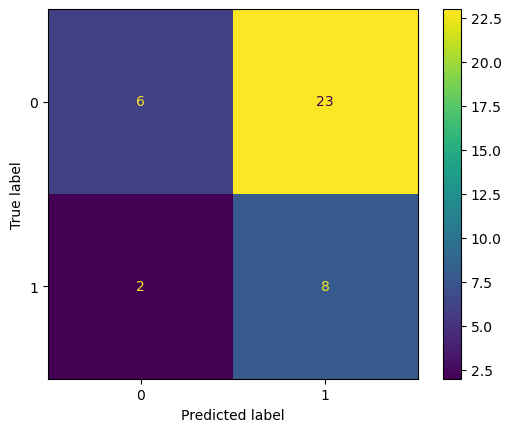

In [19]:
#docs_infra: no_execute
if numero_clases==2:
    classes = [0, 1]
else:   
    classes = [0, 1, 2, 3, 4]
#classes = [0, 1]
cm=confusion_matrix(y_test_def2, y_pred2,labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [20]:
from sklearn.metrics import classification_report
if numero_clases==2:
    target_names = ['Buenos', 'Malos']
else:   
    target_names = ['A', 'B+', 'B', 'B-','C']
print(classification_report(y_test_def2, y_pred2, target_names=target_names, digits=4))

              precision    recall  f1-score   support

      Buenos     0.7500    0.2069    0.3243        29
       Malos     0.2581    0.8000    0.3902        10

    accuracy                         0.3590        39
   macro avg     0.5040    0.5034    0.3573        39
weighted avg     0.6239    0.3590    0.3412        39



In [21]:
# model.save('modelos/modelote1203_200')  # creates a HDF5 file 'my_model.h5'

In [22]:
#model.save('idea.h5')  # creates a HDF5 file 'my_model.h5'
model.save('modelos\modelo_perfecto_{}_{}.h5'.format(experimento,datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))) 

In [23]:
from scipy import stats
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_def)
#y_pred2 = scaler_out.inverse_transform(y_pred) #valor denormalizado

#y_pred1=y_pred[:,-1]
y_pred2=np.argmax(y_pred,axis=1)

existing_file='RESULTADOS_EXCEL\clasificacion_39_AGILENT_def.xlsx'

# Verifica si el archivo existe y si está vacío
if not os.path.exists(existing_file) or os.path.getsize(existing_file) == 0:
    df_inicial=pd.DataFrame(y_test_def2, columns=["target"])
    df_inicial.to_excel(existing_file, index=False)





2/2 [==============================] - 0s 2ms/step


In [24]:
# Convierte los arrays a DataFrames
df_new = pd.DataFrame(y_pred2, columns=[experimento])
# Read existing data
df_existing = pd.read_excel(existing_file)
# Append new data
df_combined=pd.concat([df_existing, df_new], axis=1)

# Guarda los DataFrames en archivos Excel
df_combined.to_excel(existing_file, index=False)


PermissionError: [Errno 13] Permission denied: 'RESULTADOS_EXCEL\\clasificacion_39_AGILENT_def.xlsx'

In [ ]:
#este modo de guardar no funciona en esta version de tensorflow
#model.save('modelos\modelo_perfecto_{}_{}'.format(experimento,datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))) 

In [ ]:
from scipy import stats
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_def)
#y_pred2 = scaler_out.inverse_transform(y_pred) #valor denormalizado

#y_pred1=y_pred[:,-1]
y_pred2=np.argmax(y_pred,axis=1)
n = len(y_pred2)
reshaped = y_pred2[:n//4*4].reshape(-1, 4)
mean_values = reshaped.mean(axis=1)

mean_values = np.round(mean_values)
mean_values = np.clip(mean_values, 0, 4)
mean_values = mean_values.astype(int)
print(mean_values)

mode_values = stats.mode(reshaped, axis=1)[0]
print(mode_values)

# Convierte los arrays a DataFrames
mean_df = pd.DataFrame(mean_values, columns=['mean'])
mode_df = pd.DataFrame(mode_values, columns=['mode'])

# Guarda los DataFrames en archivos Excel
mean_df.to_excel("excels_borrar\clasificacion_P1P2_mean_best7.xlsx", index=False)
mode_df.to_excel("excels_borrar\clasificacion_P1_mode_best7.xlsx", index=False)

2/2 [==============================] - 0s 5ms/step
[0 1 1 0 0 1 0 0 0]
[0 1 1 0 0 1 0 0 0]


In [ ]:
print(y_pred2)

[1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 1 1
 1 0]


In [ ]:
filename5 = "COPIA_PANDAS\lomosP1_20240430_clasificado_experto.hdf"
with pd.HDFStore(filename5,complib="zlib",complevel=4) as hdf_db:
    pre_p_e2  = hdf_db.get('data/pollos_estado')
    pre_p_e2 = pre_p_e2.loc[pre_p_e2['Pollo'] != 0]
    pre_p_e2 =pre_p_e2.drop_duplicates(subset = ['Pollo', 'Medida'],  keep = 'last').reset_index(drop = True)
    t    = hdf_db.get('data/tabla')
    X_test2=np.zeros((pre_p_e2.shape[0],220,8))
    y_test2=np.zeros((pre_p_e2.shape[0],1))
    x=0
    for index, row in pre_p_e2.iterrows():   # El primer registro no se toma en cuenta porque es basura
        Primero = int(row['Primero'])
        Ultimo  = int(row['Ultimo'])
        estado  = int(row['Estado'])
        #print(Primero)
        #print(Ultimo)
        #print(estado)
        if numero_clases==2:
            if estado == 0 or estado== 1:
                target = 0 
            else:
                target = 1

        else:
            target=estado
        pepito=np.array(t.iloc[Primero:Ultimo+1])
        # #print(pepito.shape)
        X_test2[x]=pepito[:,3:4]
        #print(X_train[x][0:4,:])       
        y_test2[x]=target
        y_test2_to_categorical = to_categorical(y_test2)
        x=x+1


# print(X_train.shape)
# print(y_train_to_categorical.shape)
# #print(X_train[0:4,:,:])
# #print(X_train[1][0:4][:])
# print(y_train[1:20])
# print(y_train_to_categorical[1:20])
# # #Aqui filtrariamos si hay filas que no nos interesan. En este caso dejo pasar todos los casos
# print(p_e)
# # X_train_filtrado = X_train[2:][:,:]
# # y_train_filtrado = y_train[2:]
X_test2_filtrado = X_test2
#y_train_filtrado = y_train
y_test2_filtrado = y_test2_to_categorical

print(X_test2_filtrado.shape)
print(y_test2_filtrado.shape)
# print(X_train_filtrado[0][:,:])
# # # Vamos a normalizar o escalar los datos
# concatenamos train y test
#X_total=np.concatenate((X_train_filtrado,X_test_filtrado),axis=0)
#scaler = MinMaxScaler(feature_range=(0, 1))
#data_2d_test = X_total.reshape(-1, X_total.shape[-1])
data_2d_test = X_test2_filtrado.reshape(-1, X_test2_filtrado.shape[-1])
normalized_data_2d_test = scaler.transform(data_2d_test)


X_test2_def=normalized_data_2d_test.reshape(X_test2_filtrado.shape) 
# la alternativa es normalizar con el total
# X_test_def=normalized_data_2d_test.reshape(X_test_filtrado.shape) 

y_test2_def=y_test2_filtrado # los valores ya estaban normalizados

print(y_test2_def.shape)

print(y_test2_filtrado)

(200, 220, 8)
(200, 2)


ValueError: X has 8 features, but StandardScaler is expecting 1 features as input.

In [ ]:
from scipy import stats
from sklearn.metrics import classification_report

# # Crear un nuevo modelo con la misma arquitectura
# best_val_model = create_model()  # Reemplaza esto con la función que usaste para crear el modelo original

# # Cargar los mejores pesos
# best_val_model.load_weights('best_weights.h5')

y_pred = model.predict(X_test2_def)
#y_pred2 = scaler_out.inverse_transform(y_pred) #valor denormalizado

#y_pred1=y_pred[:,-1]
y_pred2=np.argmax(y_pred,axis=1)
n = len(y_pred2)
print(n)
reshaped = y_pred2[:n//4*4].reshape(-1, 4)
mean_values = reshaped.mean(axis=1)

mean_values = np.round(mean_values)
mean_values = np.clip(mean_values, 0, 4)
mean_values = mean_values.astype(int)
print(mean_values.shape)

mode_values = stats.mode(reshaped, axis=1)[0]
print(mode_values.shape)

n = len(y_test2_def)
y_test2_def2=np.argmax(y_test2_def,axis=1)
print(y_test_def2.shape)
print(n)
reshaped2 = y_test2_def2[:n//4*4].reshape(-1, 4)
target_mean_values = reshaped2.mean(axis=1)

target_mean_values = np.round(target_mean_values)
target_mean_values = np.clip(target_mean_values, 0, 4)
target_mean_values = target_mean_values.astype(int)
print(target_mean_values.shape)

target_mode_values = stats.mode(reshaped2, axis=1)[0]
print(target_mode_values.shape)
print(reshaped)
print(mode_values)
print(target_mean_values)

In [ ]:
#docs_infra: no_execute
if numero_clases==2:
    classes = [0, 1]    
else:

    classes = [0, 1, 2, 3, 4]
#classes = [0, 1]
cm=confusion_matrix(target_mode_values, mode_values,labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
print(cm.diagonal()/cm.sum(axis=1))

In [ ]:
if numero_clases==2:
    target_names= ['Buenos', 'Malos']
else:
    target_names= ['A', 'B+', 'B', 'B-','C']
print(classification_report(target_mode_values, mode_values, target_names=target_names, digits=4))